In this notebook we try to estimate the dimensionality of the dynamic trajectory subspace.

### Helpful articles
- [Supplementary material from AI Poincare](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.126.180604/poincare_supplemental_materialv2.pdf)
- [Interpretable conservation law estimation by deriving the symmetries of dynamics from trained deep neural networks](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.103.033303) cited in AI Poincare.

In [1]:
%pip install wasserstein umap-learn ipython ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn import metrics

In [3]:
import creating.pendulum as pend
import creating.harmonic_oscillator as ho
import creating.kepler_problem as kp
import creating.double_pendulum as dp
import creating.coupled_oscillator as co

In [4]:
%mkdir -p trajectories/coupled_oscillator
%mkdir -p trajectories/double_pendulum
%mkdir -p trajectories/harmonic_oscillator
%mkdir -p trajectories/pendulum
%mkdir -p trajectories/kepler_problem
%mkdir -p trajectories/three_body_problem

ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


In [5]:
pend.create_trajectories(5)
ho.create_trajectories(5)
kp.create_trajectories(5)
dp.create_trajectories(5)
co.create_trajectories(5)

100%|██████████| 5/5 [00:00<00:00,  5.77it/s]
5it [00:00, ?it/s]


(array([[[ 3.76839514e-01,  3.07592428e-01, -1.05415573e-02,
          -9.40311374e-03],
         [ 3.78709458e-01,  3.02886307e-01, -3.38923957e-02,
          -2.21881374e-02],
         [ 3.71193262e-01,  3.04252378e-01, -8.33019632e-02,
          -6.35291571e-02],
         ...,
         [ 2.44950778e-01,  3.15696480e-01,  2.09126513e-01,
           1.81256696e-01],
         [ 2.58905604e-01,  3.26132223e-01,  1.98724342e-01,
           1.74275026e-01],
         [ 2.59286182e-01,  3.23440297e-01,  2.00642519e-01,
           1.75935044e-01]],
 
        [[ 6.89793517e-01,  1.09736440e-01, -1.04287706e-02,
           4.97809586e-03],
         [ 6.94747716e-01,  1.11662655e-01, -1.81128921e-02,
           3.94283761e-03],
         [ 6.88448520e-01,  1.13954490e-01, -2.41039986e-02,
           7.75458843e-04],
         ...,
         [ 3.61373332e-02,  6.00310752e-01,  3.08105352e-01,
           1.84241600e-01],
         [ 4.94122221e-02,  6.06471952e-01,  3.09187938e-01,
           1.64968

In [6]:
import utils

In [7]:
class AE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, intermediate_dim: int):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, hidden_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
def rand_point(dim=3):
    x = np.random.rand(dim)
    x[0] *= np.random.choice([-1, 1])
    x[1] *= np.random.choice([-1, 1])
    return x / np.linalg.norm(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # cpu is faster ??

In [10]:
def train_model(traj, hidden_layer_dim, epochs=1000, intermediate_dim=5, batch_size=64):
    input_dim = traj.shape[1]

    model = AE(input_dim, hidden_layer_dim, intermediate_dim).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    # traj_microbatches = np.split(traj, traj.shape[0] / microbatch_size)
    # traj_microbatches = np.array([x.flatten() for x in traj_microbatches])
    dataloader = DataLoader(traj, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        batches = 0
        for batch_pts in dataloader:
            optimizer.zero_grad()
            inp = batch_pts.float().to(device)
            output = model(inp)
            loss = criterion(output, inp)
            running_loss += loss.item()
            batches += 1
            loss.backward()
            optimizer.step()
        epoch_rms = np.sqrt(running_loss / batches)
        epoch_loss.append(epoch_rms)
    return model, epoch_loss

In [11]:
def full_train(traj, max_hidden_size, epochs=1000, intermediate_dim=20, batch_size=64):
    models = []
    epoch_losses_k = []

    for hidden_layer_size in tqdm(range(1, max_hidden_size + 1)):
        model, epoch_losses = train_model(traj, hidden_layer_size, intermediate_dim=intermediate_dim, batch_size=batch_size, epochs=epochs)
        epoch_losses_k.append(epoch_losses)
        models.append(model)
    return models, epoch_losses_k

In [32]:
decision_threshold = 0.06

In [13]:
def plot_losses(experiment_name, n_eff, epoch_losses_k, max_hidden_size):
    plt.scatter(range(1, max_hidden_size + 1), np.array(epoch_losses_k)[:,-1], c=[1 if x < n_eff else 0 for x in range(1, max_hidden_size + 1)])
    plt.axhline(y=decision_threshold, color='blue', linestyle='--')
    plt.title(f"{experiment_name}. n_eff={n_eff}")
    plt.xlabel("hidden layer size")
    plt.ylabel("r.m.s. loss after auto-encoder")
    plt.show()

    plotted_loss = epoch_losses_k[n_eff - 1]
    plt.plot(range(len(plotted_loss)), plotted_loss)
    plt.title(f"{experiment_name}. model with {n_eff} hidden dim")
    plt.xlabel("iteration")
    plt.ylabel("r.m.s.")
    plt.show()

## 5-dimensional sphere (example)

In [33]:
experiment_name = "sphere5"
traj_s5 = np.array([rand_point(dim=5) for x in range(1000)])
print(traj_s5.shape)
n_eff = 4 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 5)


In [15]:
models_s5, epochs_s5 = full_train(traj_s5, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

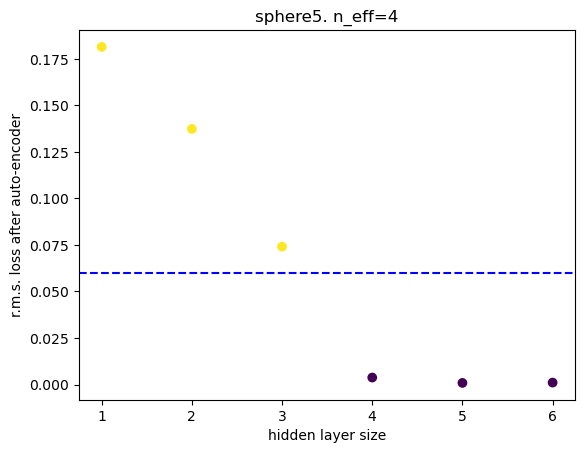

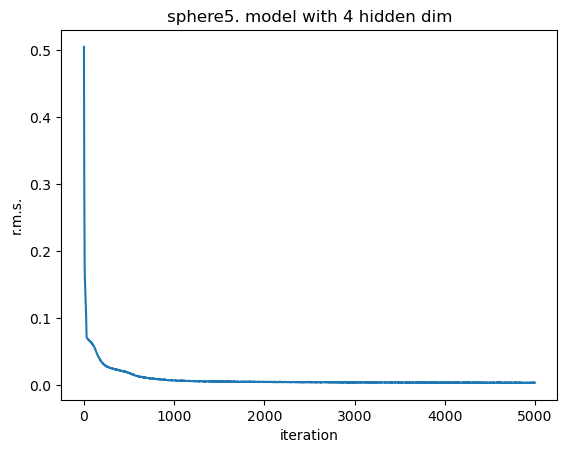

In [34]:
plot_losses(experiment_name, n_eff, epochs_s5, max_hidden_size)

## Pendulum

In [35]:
experiment_name = "pendulum"
traj_p = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_p.shape)
n_eff = 1 # ground truth
max_hidden_size = 4
epochs = 5000

(1000, 2)


In [18]:
models_p, epochs_p = full_train(traj_p, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

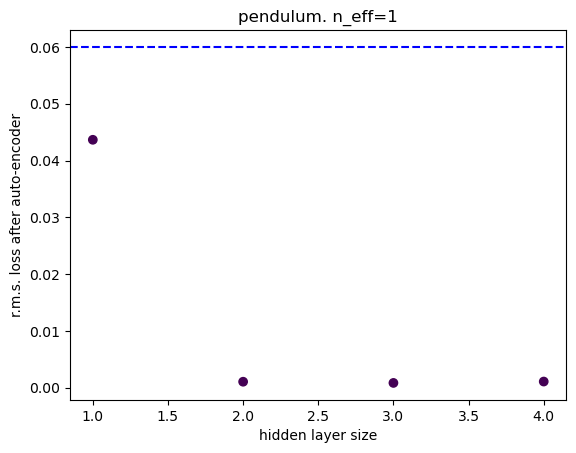

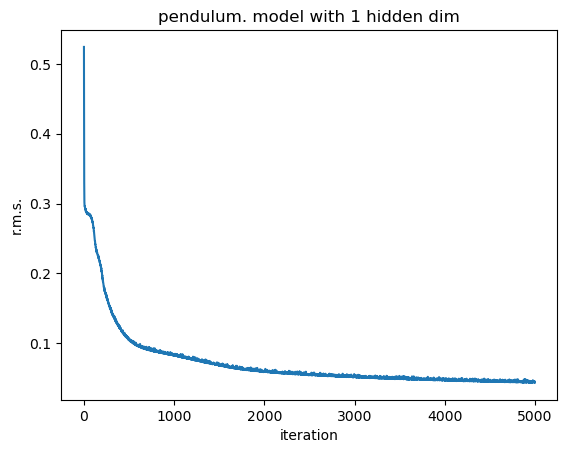

In [36]:
plot_losses(experiment_name, n_eff, epochs_p, max_hidden_size)

## Harmonic oscillator

In [37]:
experiment_name = "harmonic_oscillator"
traj_h = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_h.shape)
n_eff = 1 # ground truth
max_hidden_size = 4
epochs = 5000

(1000, 2)


In [21]:
models_h, epochs_h = full_train(traj_h, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

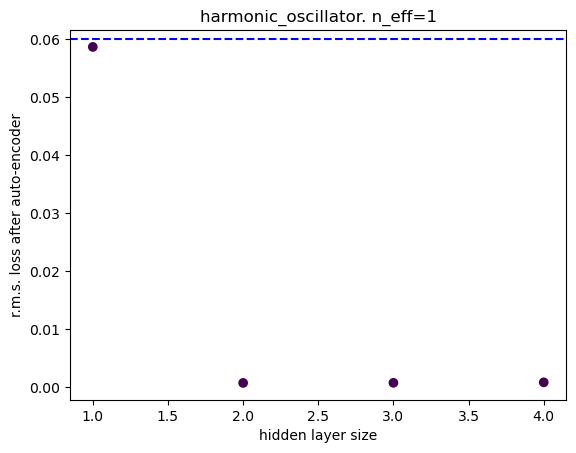

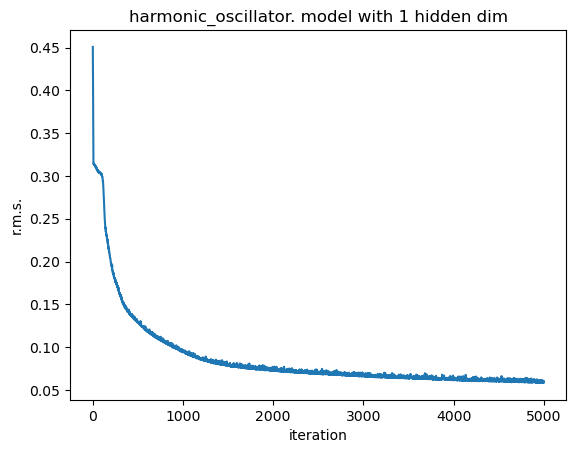

In [38]:
plot_losses(experiment_name, n_eff, epochs_h, max_hidden_size)

## Double pendulum

In [39]:
experiment_name = "double_pendulum"
traj_dp = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_dp.shape)
n_eff = 3 # ground truth
max_hidden_size = 7
epochs = 5000

(1000, 4)


In [24]:
models_dp, epochs_dp = full_train(traj_dp, max_hidden_size, epochs=epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

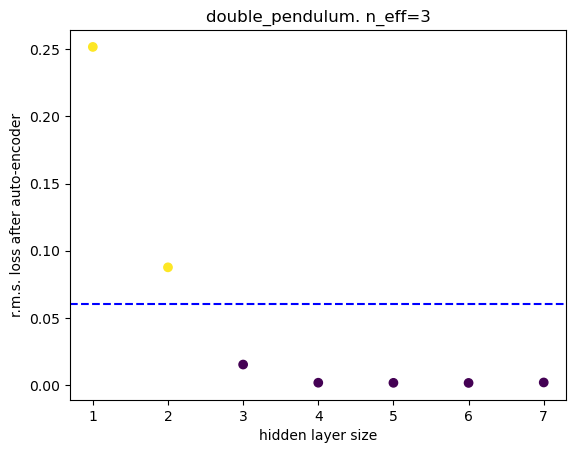

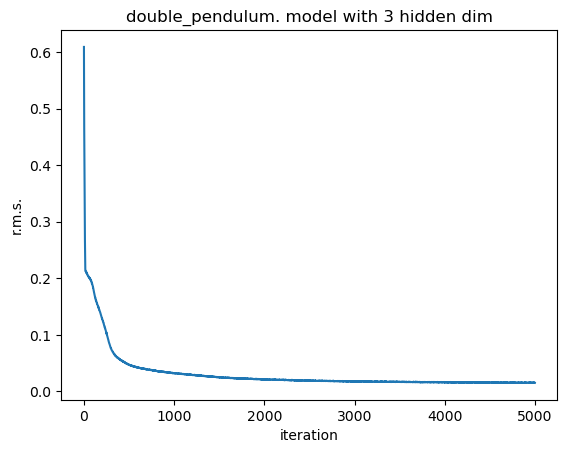

In [40]:
plot_losses(experiment_name, n_eff, epochs_dp, max_hidden_size)

## Coupled oscillator

In [41]:
experiment_name = "coupled_oscillator"
traj_co = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_co.shape)
n_eff = 2 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 4)


In [27]:
models_co, epochs_co = full_train(traj_co, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

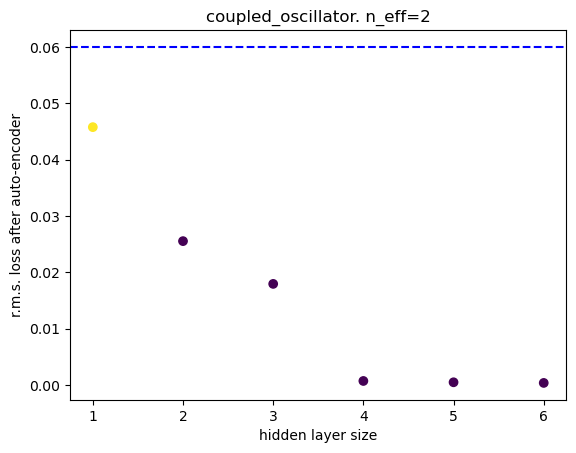

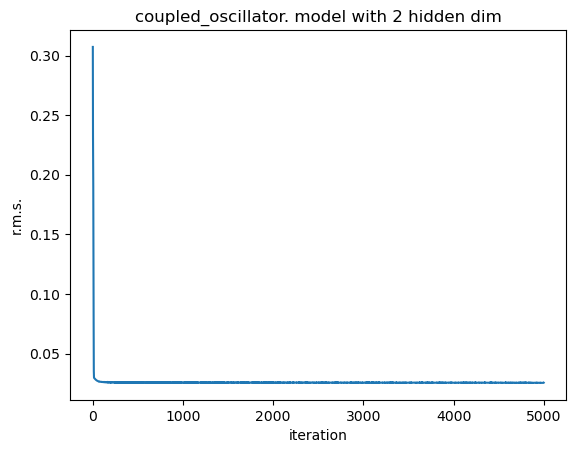

In [42]:
plot_losses(experiment_name, n_eff, epochs_co, max_hidden_size)

## Kepler problem

In [43]:
experiment_name = "kepler_problem"
traj_kp = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_kp.shape)
n_eff = 1 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 4)


In [30]:
models_kp, epochs_kp = full_train(traj_co, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

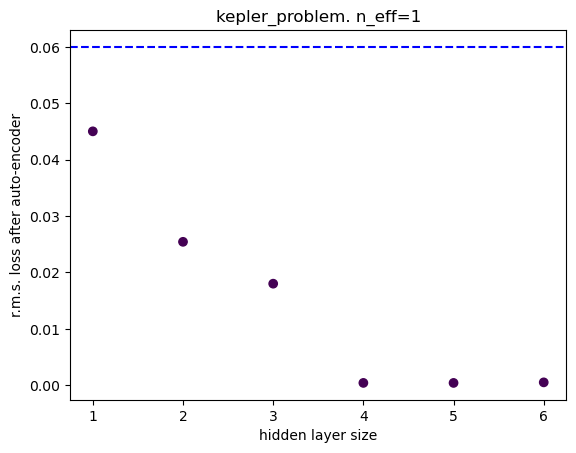

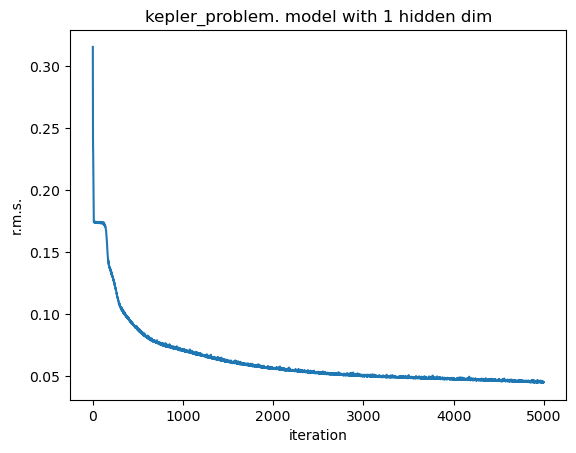

In [44]:
plot_losses(experiment_name, n_eff, epochs_kp, max_hidden_size)